In [73]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
from training import trainNet
from dataset import ImageDataset
import copy

# Fix seed for duplication
np.random.seed(123)
torch.manual_seed(123)

## Load data
Let's load the dataset

The label is :
7


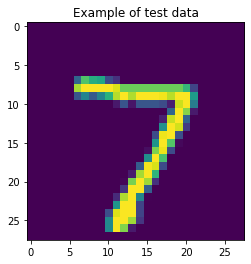

In [76]:
# Load input data and labels
data = torch.load("test.pt")
X = data[0]
Y = data[1]

# Visualize data
dataset = ImageDataset(X,Y) 
img = dataset[0][0]
label = dataset[0][1]
plt.imshow(img.numpy()[0])
plt.title("Example of test data")
print("The label is :")
print(label.numpy())

# Generate batches of test data(with imageDataset class above and torch.utils.data.DataLoader class)
testDataSet = ImageDataset(X,Y)
evalLoader = DataLoader(testDataSet,batch_size=64,shuffle=True)

## CNN model
This is a simple convolutionnal network with two convolutionnal layers and two dense layers.

In [77]:
class MyNetwork(nn.Module):

    def __init__(self):
        super(MyNetwork, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(784, 128) 
        self.fc2 = nn.Linear(128, 10)
        self.bn = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.5)


    # Forward function of the classification model
    def forward(self, input):
        x = torch.reshape(input, (input.shape[0],-1))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

## Evaluate the model
The model has allready been trained and is stored on netMNIST.pt. Let's check if it works

In [82]:
# Load classification model with its weights
model = MyNetwork()
model.load_state_dict(torch.load('netMNIST05.pt'))
model.eval()

# Generate batches of test data 
loader_test = evalLoader

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

# Testing
with torch.no_grad(): # no gradient
    for i, data in enumerate(loader_test):

        # Load image and class inside a batch 
        imgs = data[0]
        labels = data[1]

        # Apply the model
        preds = model(imgs)
        v, i = torch.max(preds,1)

        # Append batch prediction results
        predlist=torch.cat([predlist,i.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Display results
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

# accuracy
print(np.mean(class_accuracy))
    

[[ 965    0    0    1    0    1    8    2    2    1]
 [   0 1122    3    2    0    0    4    0    4    0]
 [   9    0  973    6    8    0    7    9   20    0]
 [   0    0    8  970    0    2    1   10   14    5]
 [   0    2    4    0  923    0   11    1    5   36]
 [   4    2    1   26    3  827   14    2    7    6]
 [   7    3    0    0    3    5  936    0    4    0]
 [   2   15   16    5    2    0    1  964    0   23]
 [   5    3    4   10    7    2    4    3  931    5]
 [   9    7    0   12   11    1    0    4   11  954]]
[98.46938776 98.85462555 94.28294574 96.03960396 93.99185336 92.71300448
 97.70354906 93.77431907 95.58521561 94.54905847]
95.59635630535632


# Monte-Carlo Dropout
Let's evaluate the covariance of a measurement of the model with Monte-Carlo dropout 

In [79]:
def monteCarloDropoutPredictions(img, model, n):
  preds = np.zeros((n,10))
  model.train()
  for k in range(n):
    pred = model(img)
    preds[k,:] = pred.detach().numpy()[0]
  return preds

def mean_and_cov(preds):
  # for np.cov: rows=variable, columns=datapoints
  return np.mean(preds, axis=0), np.cov(preds.T)

def monteCarloDropout(img, model, n):
  preds = monteCarloDropoutPredictions(img, model, n)
  return mean_and_cov(preds)

def show_field(field1,field2):

    combined_data = np.array([field1,field2])
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    #Add the vmin and vmax arguments to set the color scale
    ax.imshow(field1, vmin = _min, vmax = _max)
    ax.autoscale(False)
    ax2 = fig.add_subplot(1, 2, 2)
    #Add the vmin and vmax arguments to set the color scale
    ax2.imshow(field2, vmin = _min, vmax = _max)
    ax2.autoscale(False)
    plt.colorbar(ax2.imshow(field2, vmin = _min, vmax = _max))
    plt.show()

Let's compute the covariance matrix for an image in the training data range

Mean estimation : 1


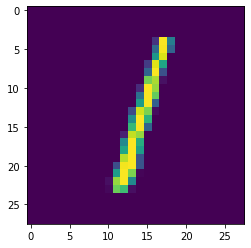

In [52]:
# select an image in the evaluation se
i = 2
img = torch.unsqueeze(testDataSet[i][0],0)

avg0, cov0 = monteCarloDropout(img,model,300)
numpyImage = img.numpy()        
plt.imshow(numpyImage[0][0])
class0 =  np.argmax(avg0)
print("Mean estimation : {}".format(class0))


Now let's compute the matrix for a noisy image

Mean estimation : 2


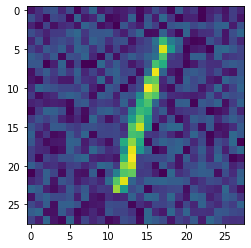

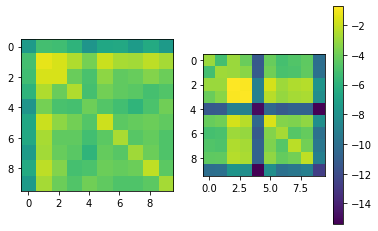

In [53]:
# We generate an unknown image
sigma = 0.5
noise = sigma*np.random.rand(28,28)
# randIm = img[0][0].numpy()[::-1,::-1]
im = img[0][0].numpy() + noise
noisyTensor = torch.unsqueeze(torch.FloatTensor(im),0)
noisyTensor = torch.unsqueeze(noisyTensor,0)

# Let's compute the covariance matrix
plt.imshow(noisyTensor.numpy()[0][0])
avg1, cov1 = monteCarloDropout(noisyTensor,model,300)
class1 =  np.argmax(avg1)
print("Mean estimation : {}".format(class1))

show_field(np.log10(np.abs(cov0)),np.log10(np.abs(cov1)))

Let's try it for a rotated image

Mean estimation : 3


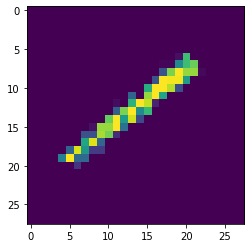

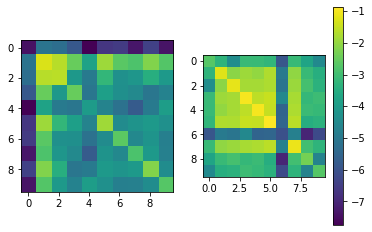

In [54]:
# let's rotate the image
angle = 145
rotatedTensor = TF.rotate(img, angle)


# Let's compute the covariance matrix
plt.imshow(rotatedTensor.numpy()[0][0])
avg2, cov2 = monteCarloDropout(rotatedTensor,model,300)
class2 =  np.argmax(avg2)
print("Mean estimation : {}".format(class2))

show_field(np.log10(np.abs(cov0)),np.log10(np.abs(cov2)))

## Reproduce Gal 2019 graphs


In [83]:
angles = [0,5,10,15,20,25,30,35,40,45]
nb_angles = len(angles)
sample_size = 100

# select an image in the evaluation se
i = 2
img = torch.unsqueeze(testDataSet[i][0],0)

images =        np.zeros((nb_angles, *img.shape))
preds_per_img = np.zeros((nb_angles, sample_size, 10))
mean_per_img =  np.zeros((nb_angles, 10))
cov_per_img =   np.zeros((nb_angles, 10, 10))

for i, angle in enumerate(angles):
    rotatedTensor = TF.rotate(img, angle)
    images[i] = rotatedTensor.numpy()[0,0]
    preds = monteCarloDropoutPredictions(rotatedTensor, model, sample_size)
    preds_per_img[i] = preds
    mean, cov = mean_and_cov(preds)
    mean_per_img[i] = mean
    cov_per_img[i] = cov




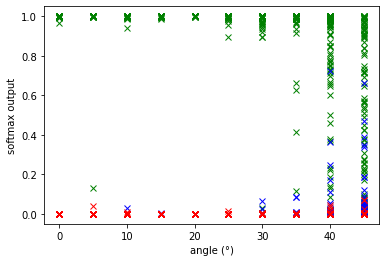

In [84]:
plt.figure()
plt.plot(angles, preds_per_img[:,:,1], 'gx')
plt.plot(angles, preds_per_img[:,:,5], 'bx')
plt.plot(angles, preds_per_img[:,:,7], 'rx')
plt.xlabel('angle (°)')
plt.ylabel('softmax output')
plt.show()

